In [1]:
from simulator import NetworkSimulator
from matplotlib import pyplot as plt
from random import choice
import random
import collections
import numpy as np

In [2]:
class QPacketRouter():
 
  def __init__(self, simulator):
    self.simulator=simulator
    self.Q = collections.defaultdict(float)
    self.epsilon = 0.05
    self.learning_rate = 0.01
    self.dropped_penalty = 0.01

  # returns best next step for packet from src to dst for min Q
  def min_Q(self, src, dst):
    src_neighbours = self.simulator.G.neighbors(src)
    min_Q = float('inf')
    min_node = None
    for neighbor in src_neighbours:
      if self.Q[(src, dst, neighbor)] < min_Q:
        min_Q = self.Q[(src, dst, neighbor)]
        min_node = neighbor
    return min_node, min_Q
 
  def update_Q(self, cur, nxt, packet):
    min_node, min_q = self.min_Q(nxt, packet.dst)
    travel_time = self.simulator.traverseEdge(packet, cur, nxt)

    if packet.dropped:
      edge_attr = self.simulator.get_edge_attr(cur, nxt)
      min_node, min_q = self.min_Q(packet.src, packet.dst)
      # penalty
      min_q *= 1. + self.dropped_penalty * (edge_attr.dropped_packets ** (1/3))
    
    # bellman equation
    # q_val(cur, final_dst, next) = q_val(cur, final_dst, next) + learningrate(min_q from src to dest + travel time (value) - q_val(cur, final_dst, next)) 
    self.Q[(cur, packet.dst, nxt)] += self.learning_rate * (min_q + travel_time - self.Q[(cur, packet.dst, nxt)])

    if packet.dropped:
      return None
    else:
      return next

  def routePacketSingleStep(self, packet, cur):
    # exloration
    if random.random() < self.epsilon:
      nxt = choice(list(self.simulator.G.neighbors(cur)))
    # exploitation
    else:
      nxt, x = self.min_Q(cur, packet.dst)
    return self.update_Q(cur, nxt, packet)
  
  def Q_table(self):
    return self.Q

In [3]:
def get_averages(total_times, packet_count):
    get_avg=[]
    for i in range(int(len(total_times)/packet_count)):
        get_avg.append(sum(total_times[i*packet_count:(i+1)*packet_count])/packet_count)
    return get_avg

In [4]:
nodes = 25
packets = 50000

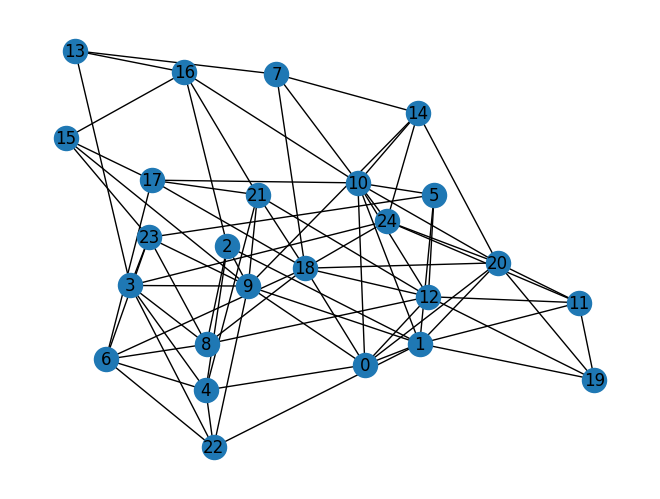

In [5]:
n_s = NetworkSimulator(nodes)
q_packet_router = QPacketRouter(n_s)
n_s.network_viz()

# testpacket- is a list
test_packets = n_s.generate_packets(packets)
packet_count = 100

In [6]:
print("Q-Routing:")
# packets, qpacketsimulator, number of packets, drop nodes=True                               
n_s.train_Q(test_packets, q_packet_router, 100)

total_times = [packet.totalTime for packet in test_packets]
q_average_times = get_averages(total_times, packet_count)

Q-Routing:
 avg path length:       6.705680
 avg transmission time: 1254.830815
 timed out packets:        594.000000
 total dropped packets :   126019


In [7]:
table=q_packet_router.Q_table()
table

defaultdict(float,
            {(9, 13, 2): 327.58395468406263,
             (9, 13, 14): 325.47652858483616,
             (9, 13, 21): 325.41174886297676,
             (9, 13, 1): 325.2264876923165,
             (9, 13, 22): 326.2029723192363,
             (9, 13, 3): 325.3975034965606,
             (9, 13, 0): 327.12967363831206,
             (9, 13, 15): 325.3300270180936,
             (9, 13, 23): 325.89076077325694,
             (2, 13, 8): 355.95781038801107,
             (2, 13, 9): 355.6943769093336,
             (2, 13, 1): 356.1397225850091,
             (2, 13, 4): 355.90377446133687,
             (2, 13, 16): 356.6736090913293,
             (18, 5, 17): 202.52313689763682,
             (18, 5, 21): 202.46611388540572,
             (18, 5, 7): 203.6179006413472,
             (18, 5, 6): 202.51693073136445,
             (18, 5, 24): 203.52181945213073,
             (18, 5, 0): 202.4372646145633,
             (18, 5, 8): 202.82274747959002,
             (18, 5, 12): 203.167106

Text(0.5, 0, 'iteration (100 packets)')

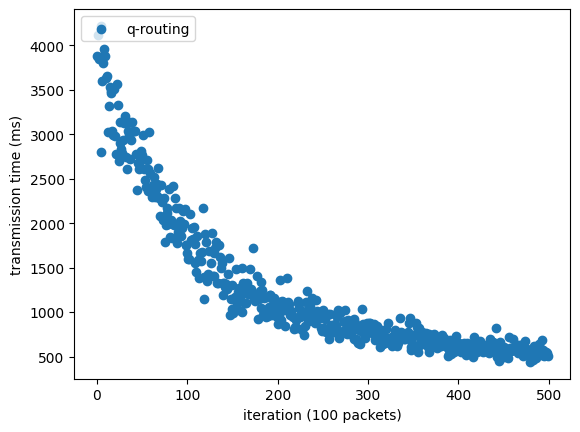

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(range(len(q_average_times)), q_average_times, label="q-routing")
plt.legend(loc='upper left')
plt.ylabel("transmission time (ms)")
plt.xlabel("iteration (100 packets)")